In [29]:
# 📌 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras.models import load_model
import sys
sys.path.append('../src')
from data_preprocessing import prepare_model_data
from utils import save_fig


In [30]:
# Load the data
data = pd.read_csv('../data/processed/btc_features.csv')

# Convert 'Date' to datetime (If not already in datetime)
data['Date'] = pd.to_datetime(data['Date'])

# Prepare model data to get scaler and seq length
seq_length = 10  # or whatever you used
model_data = prepare_model_data(data, seq_length=seq_length)
scaler = model_data['scaler']


In [31]:
# Extract the last sequence of values from 'Price' or another relevant feature
last_sequence = data['Price'].values[-seq_length:]  # Using 'Price' here (replace if needed)
scaled_sequence = scaler.transform(last_sequence.reshape(-1, 1))

# Number of days to predict
forecast_horizon = 30


In [32]:
# Load LSTM model
lstm_model = load_model('../models/lstm_model.keras')

input_seq = scaled_sequence
lstm_predictions = []

for _ in range(forecast_horizon):
    pred = lstm_model.predict(input_seq.reshape(1, seq_length, 1), verbose=0)
    lstm_predictions.append(pred[0][0])
    input_seq = np.append(input_seq[1:], pred).reshape(seq_length, 1)

# Inverse transform LSTM predictions
lstm_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))


In [33]:
bilstm_model = load_model('../models/bilstm_model.keras')

input_seq = scaled_sequence
bilstm_predictions = []

for _ in range(forecast_horizon):
    pred = bilstm_model.predict(input_seq.reshape(1, seq_length, 1), verbose=0)
    bilstm_predictions.append(pred[0][0])
    input_seq = np.append(input_seq[1:], pred).reshape(seq_length, 1)

bilstm_forecast = scaler.inverse_transform(np.array(bilstm_predictions).reshape(-1, 1))


In [34]:
# Average LSTM and BiLSTM predictions
lstm_bilstm_avg_forecast = (lstm_forecast + bilstm_forecast) / 2

In [35]:
# Get the last date from the data
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_horizon)

✅ Figure saved: ../outputs/figures\Final_30Day_Forecast_LSTM_BiLSTM_Avg.png


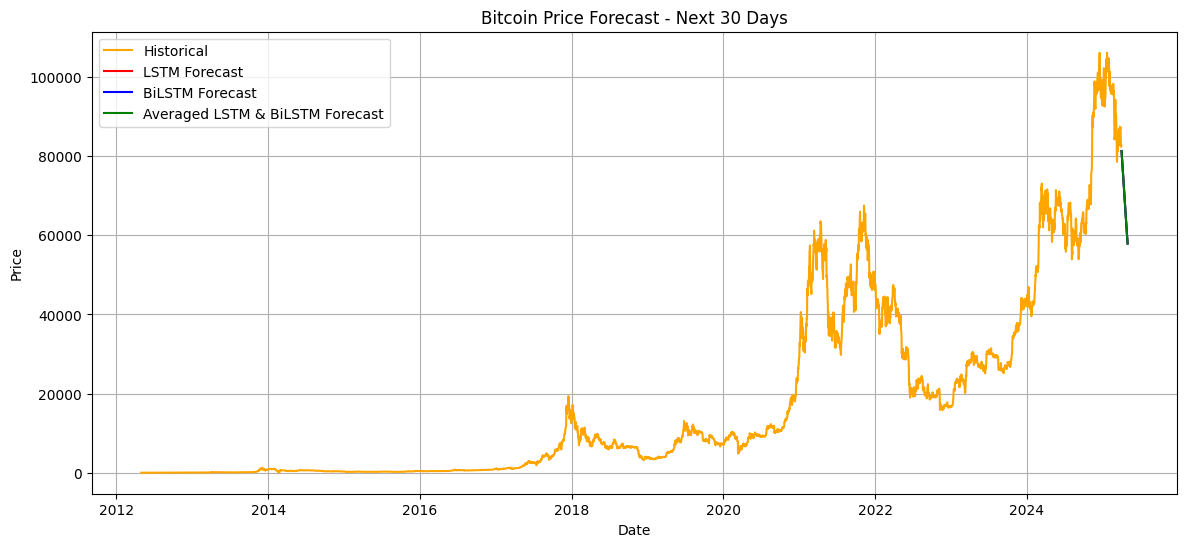

In [36]:
plt.figure(figsize=(14,6))
plt.plot(data['Date'], data['Price'], label='Historical', color='orange')  # Plot the historical data
plt.plot(future_dates, lstm_forecast, label='LSTM Forecast', color='red')
plt.plot(future_dates, bilstm_forecast, label='BiLSTM Forecast', color='blue')
plt.plot(future_dates, lstm_bilstm_avg_forecast, label='Averaged LSTM & BiLSTM Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Forecast - Next 30 Days')
plt.legend()
plt.grid(True)
save_fig("Final_30Day_Forecast_LSTM_BiLSTM_Avg")
plt.show()


In [37]:
df_forecast = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Price': lstm_forecast.flatten(),
    'BiLSTM_Price': bilstm_forecast.flatten(),
    'Averaged_LSTM_BiLSTM_Price': lstm_bilstm_avg_forecast.flatten()
})

df_forecast.to_csv('../outputs/metrics/final_forecasts_lstm_bilstm_avg.csv', index=False)